In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoNormal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam 
from pyro.infer import Predictive

In [25]:
def model2(obs):
    """
    Inputs: 
        obs: A 1D tensor of observed data. The length should be equal to the number of games played.
             Represents the outcome of a game in the eyes of coach 1, i.e. coach 1 wins: obs = 1, coach 2 wins: obs = -1.

    Output: A 1D tensor of the same length as the input tensor. Represents a sample from difference in performance between the two coaches.
    """
    
    hyper_sigma = 1/8 # consider if this variable is maintained constant during inference.
    # do we want it to be constant?
    
    coach1_mu_skill = 0
    coach1_sigma_skill = 1
    coach1_skill = pyro.sample("coach1_skill", dist.Normal(coach1_mu_skill, coach1_sigma_skill))
    coach2_mu_skill = 0
    coach2_sigma_skill = 1
    coach2_skill = pyro.sample("coach2_skill", dist.Normal(coach2_mu_skill, coach2_sigma_skill))
    
    with pyro.plate('matches', obs.shape[0]):   

        coach1_perf = pyro.sample('coach1_perf', dist.Normal(coach1_skill, hyper_sigma))
        coach2_perf = pyro.sample('coach2_perf', dist.Normal(coach2_skill, hyper_sigma))

        perf_diff = coach1_perf - coach2_perf
    
        y = pyro.sample("y_coach1_win", dist.Normal(perf_diff, hyper_sigma), obs=obs)

    return y

# Training on fake data where coach 1 always wins.

In [26]:
pyro.clear_param_store()

optimizer = Adam({"lr": 0.01})
guide = AutoNormal(model2)
svi = SVI(model2, guide, optimizer, loss=Trace_ELBO())

# Training loop
num_steps = 5000
num_games = 100

# train the model on fake data where coach 1 always wins.
obs = torch.ones(num_games)
for step in range(num_steps):    
    loss = svi.step(obs)
    if step % 100 == 0:
        print(f"Step {step} : loss = {loss}")


Step 0 : loss = 3126.0321068167686
Step 100 : loss = -26.966786980628967
Step 200 : loss = -36.95265483856201
Step 300 : loss = -37.11809527873993
Step 400 : loss = -4.90377402305603
Step 500 : loss = -32.58895301818848
Step 600 : loss = -42.97808253765106
Step 700 : loss = -35.866085171699524
Step 800 : loss = -30.268113255500793
Step 900 : loss = -44.66067433357239
Step 1000 : loss = -33.95308840274811
Step 1100 : loss = -33.63521063327789
Step 1200 : loss = -33.02695906162262
Step 1300 : loss = -24.383780002593994
Step 1400 : loss = -27.79146981239319
Step 1500 : loss = -41.98331570625305
Step 1600 : loss = -24.8796865940094
Step 1700 : loss = -30.985281586647034
Step 1800 : loss = -32.560503125190735
Step 1900 : loss = -29.853589296340942
Step 2000 : loss = -27.645017385482788
Step 2100 : loss = -33.45878505706787
Step 2200 : loss = -38.71383583545685
Step 2300 : loss = -37.94454109668732
Step 2400 : loss = -31.587631583213806
Step 2500 : loss = -23.900943875312805
Step 2600 : loss

In [27]:
predictive = Predictive(model2, guide=guide, num_samples=2000,
                        return_sites=("coach1_skill", "coach2_skill"))

samples = predictive(obs)

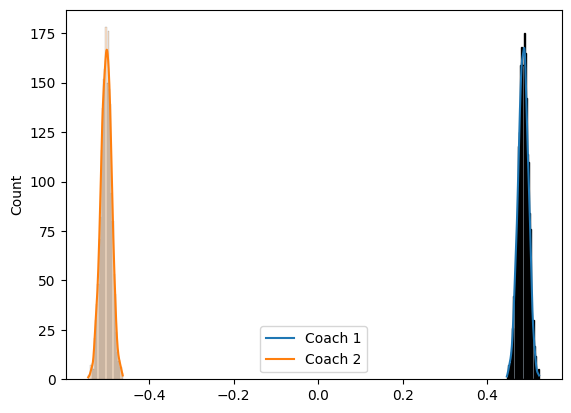

In [28]:
import seaborn as sns

#Plotting the data
coach1_skill_inf = samples["coach1_skill"].detach().squeeze()
coach2_skill_inf= samples["coach2_skill"].detach().squeeze()

sns.histplot(coach1_skill_inf, kde=True, alpha=0.2)
sns.histplot(coach2_skill_inf, kde=True, alpha=0.2)
plt.legend(["Coach 1", "Coach 2"])
plt.show()

# Training on fake data where each match is a draw.

In [29]:
pyro.clear_param_store()

optimizer = Adam({"lr": 0.01})
guide = AutoNormal(model2)
svi = SVI(model2, guide, optimizer, loss=Trace_ELBO())

# Training loop
num_steps = 5000
num_games = 100

obs = torch.zeros(num_games)
for step in range(num_steps):    
    loss = svi.step(obs)
    if step % 100 == 0:
        print(f"Step {step} : loss = {loss}")

Step 0 : loss = 28.00444859266281
Step 100 : loss = 2.001703679561615
Step 200 : loss = -36.37227779626846
Step 300 : loss = -15.682325601577759
Step 400 : loss = -22.717364132404327
Step 500 : loss = -18.754546761512756
Step 600 : loss = -27.778072476387024
Step 700 : loss = -25.834584593772888
Step 800 : loss = -37.03017735481262
Step 900 : loss = -26.763249397277832
Step 1000 : loss = -37.64205628633499
Step 1100 : loss = -33.992685079574585
Step 1200 : loss = -27.143168687820435
Step 1300 : loss = -24.912649989128113
Step 1400 : loss = -20.272641599178314
Step 1500 : loss = -24.098961532115936
Step 1600 : loss = -30.640725433826447
Step 1700 : loss = -29.35458892583847
Step 1800 : loss = -45.68520736694336
Step 1900 : loss = -41.927522361278534
Step 2000 : loss = -34.87598043680191
Step 2100 : loss = -38.72289597988129
Step 2200 : loss = -25.419646441936493
Step 2300 : loss = -35.938227474689484
Step 2400 : loss = -27.86714518070221
Step 2500 : loss = -23.33668541908264
Step 2600 :

In [30]:
predictive = Predictive(model2, guide=guide, num_samples=2000,
                        return_sites=("coach1_skill", "coach2_skill"))

samples = predictive(obs)

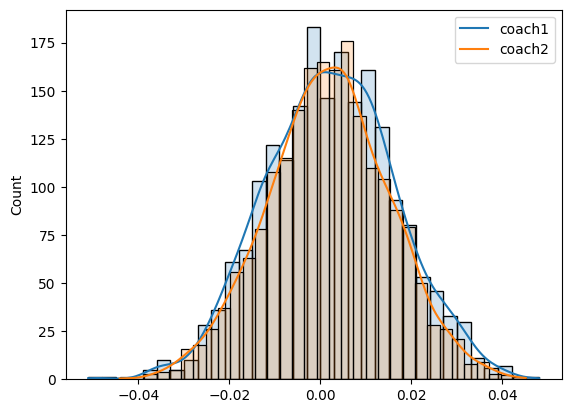

In [31]:
#Plotting the data
coach1_skill_inf = samples["coach1_skill"].detach().squeeze()
coach2_skill_inf= samples["coach2_skill"].detach().squeeze()

sns.histplot(coach1_skill_inf, kde=True, alpha=0.2)
sns.histplot(coach2_skill_inf, kde=True, alpha=0.2)
plt.legend(["coach1", "coach2"])
plt.show()

# Training on fake data where coach 2 always wins.

In [32]:
pyro.clear_param_store()

optimizer = Adam({"lr": 0.01})
guide = AutoNormal(model2)
svi = SVI(model2, guide, optimizer, loss=Trace_ELBO())

# Training loop
num_steps = 5000
num_games = 100

obs = -torch.ones(num_games)
for step in range(num_steps):    
    loss = svi.step(obs)
    if step % 100 == 0:
        print(f"Step {step} : loss = {loss}")

Step 0 : loss = 3131.5741663575172
Step 100 : loss = -9.799272894859314
Step 200 : loss = -24.86544954776764
Step 300 : loss = -34.78573203086853
Step 400 : loss = -18.754692912101746
Step 500 : loss = -41.29619121551514
Step 600 : loss = -30.16103231906891
Step 700 : loss = -33.470234513282776
Step 800 : loss = -29.116241097450256
Step 900 : loss = -29.096529364585876
Step 1000 : loss = -36.503740549087524
Step 1100 : loss = -33.24530911445618
Step 1200 : loss = -35.16153800487518
Step 1300 : loss = -31.350614547729492
Step 1400 : loss = -21.183050274848938
Step 1500 : loss = -29.76356565952301
Step 1600 : loss = -38.680381178855896
Step 1700 : loss = -26.15708637237549
Step 1800 : loss = -34.627681851387024
Step 1900 : loss = -17.689921736717224
Step 2000 : loss = -28.25780165195465
Step 2100 : loss = -34.537869572639465
Step 2200 : loss = -35.924920320510864
Step 2300 : loss = -40.33509385585785
Step 2400 : loss = -41.691999673843384
Step 2500 : loss = -39.35694897174835
Step 2600 :

In [33]:
predictive = Predictive(model2, guide=guide, num_samples=2000,
                        return_sites=("coach1_skill", "coach2_skill"))

samples = predictive(obs)

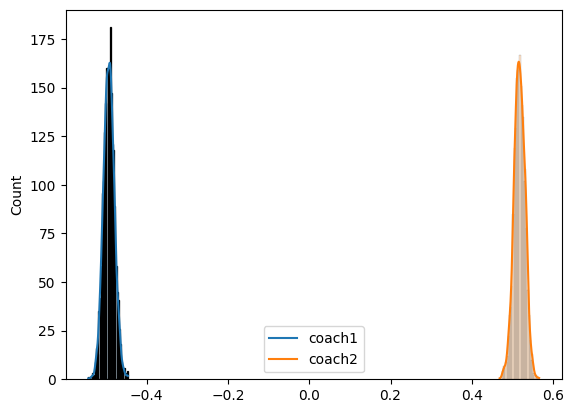

In [34]:
#Plotting the data
coach1_skill_inf = samples["coach1_skill"].detach().squeeze()
coach2_skill_inf= samples["coach2_skill"].detach().squeeze()

sns.histplot(coach1_skill_inf, kde=True, alpha=0.2)
sns.histplot(coach2_skill_inf, kde=True, alpha=0.2)
plt.legend(["coach1", "coach2"])
plt.show()

# Comparing distributions from fake data based on number of games played.

In [35]:
optimizer = Adam({"lr": 0.01})

# variables to save results
coach1_skill_inf = np.empty((3, 2000))
coach2_skill_inf = np.empty((3, 2000))

for i in range(1,4):
    pyro.clear_param_store()

    # Training loop
    num_steps = 5000
    num_games = 10**i

    guide = AutoNormal(model2)
    svi = SVI(model2, guide, optimizer, loss=Trace_ELBO())

    print(f"Training for {num_games} games")

    obs = torch.ones(num_games)
    for step in range(num_steps):    
        loss = svi.step(obs)

    predictive = Predictive(model2, guide=guide, num_samples=2000,
                            return_sites=("coach1_skill", "coach2_skill"))

    samples = predictive(obs)

    coach1_skill_inf[i-1] = samples["coach1_skill"].detach().squeeze()
    coach2_skill_inf[i-1] = samples["coach2_skill"].detach().squeeze()



Training for 10 games
Training for 100 games
Training for 1000 games


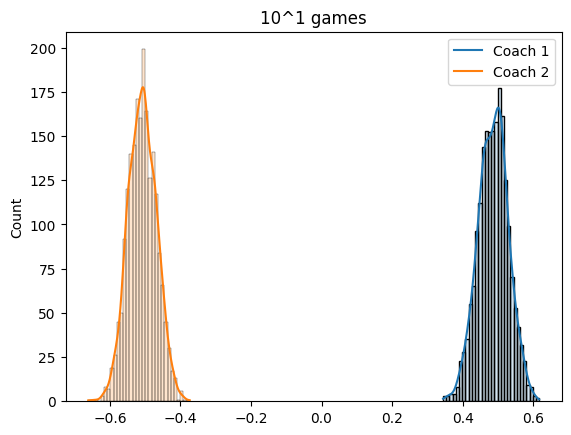

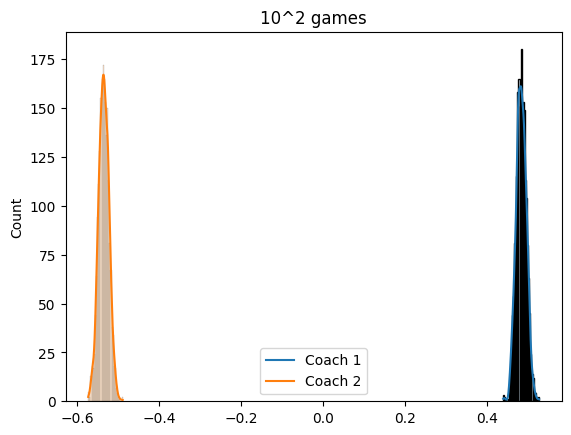

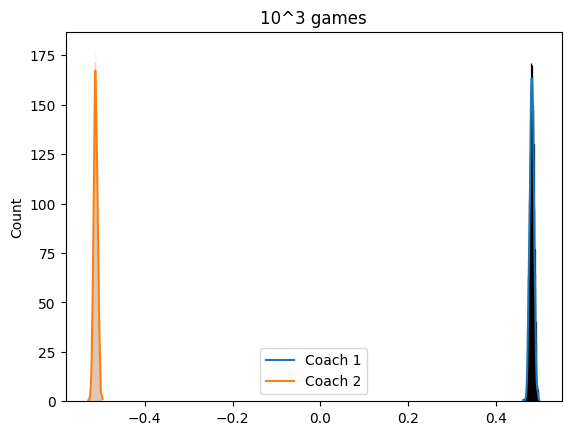

In [36]:
#Plotting the data
sns.histplot(coach1_skill_inf[0], kde=True, alpha=0.2)
sns.histplot(coach2_skill_inf[0], kde=True, alpha=0.2)
plt.title("10^1 games")
plt.legend(["Coach 1", "Coach 2"])
plt.show()

sns.histplot(coach1_skill_inf[1], kde=True, alpha=0.2)
sns.histplot(coach2_skill_inf[1], kde=True, alpha=0.2)
plt.title("10^2 games")
plt.legend(["Coach 1", "Coach 2"])
plt.show()

sns.histplot(coach1_skill_inf[2], kde=True, alpha=0.2)
sns.histplot(coach2_skill_inf[2], kde=True, alpha=0.2)
plt.title("10^3 games")
plt.legend(["Coach 1", "Coach 2"])
plt.show()

# Lets try and make some fake data where coach 1 starts by losing but slowly gets better.

In [37]:
obs1 = -torch.ones(100)
obs2 = torch.zeros(100)
obs3 = torch.ones(200)

obs = torch.cat((obs1, obs2, obs3))

pyro.clear_param_store()

optimizer = Adam({"lr": 0.01})
guide = AutoNormal(model2)
svi = SVI(model2, guide, optimizer, loss=Trace_ELBO())

# Training loop
num_steps = 5000

for step in range(num_steps):    
    loss = svi.step(obs)
    if step % 100 == 0:
        print(f"Step {step} : loss = {loss}")

Step 0 : loss = 9522.317188560963


Step 100 : loss = 2914.79979211092
Step 200 : loss = 2886.565900504589
Step 300 : loss = 2826.241234779358
Step 400 : loss = 2769.8708007335663
Step 500 : loss = 2785.479966700077
Step 600 : loss = 2807.864278614521
Step 700 : loss = 2784.997269690037
Step 800 : loss = 2786.235098183155
Step 900 : loss = 2792.943576872349
Step 1000 : loss = 2779.9934463500977
Step 1100 : loss = 2781.629343509674
Step 1200 : loss = 2781.915160179138
Step 1300 : loss = 2751.3054000735283
Step 1400 : loss = 2762.0445615053177
Step 1500 : loss = 2763.8644583821297
Step 1600 : loss = 2785.6296651363373
Step 1700 : loss = 2762.4673290252686
Step 1800 : loss = 2762.5354180336
Step 1900 : loss = 2769.5310938954353
Step 2000 : loss = 2799.4221680164337
Step 2100 : loss = 2787.998417377472
Step 2200 : loss = 2787.537132680416
Step 2300 : loss = 2786.571065545082
Step 2400 : loss = 2787.744773507118
Step 2500 : loss = 2773.196148991585
Step 2600 : loss = 2798.641106069088
Step 2700 : loss = 2776.321596264839
Step

In [38]:
predictive = Predictive(model2, guide=guide, num_samples=2000,
                        return_sites=("coach1_skill", "coach2_skill"))

samples = predictive(obs)

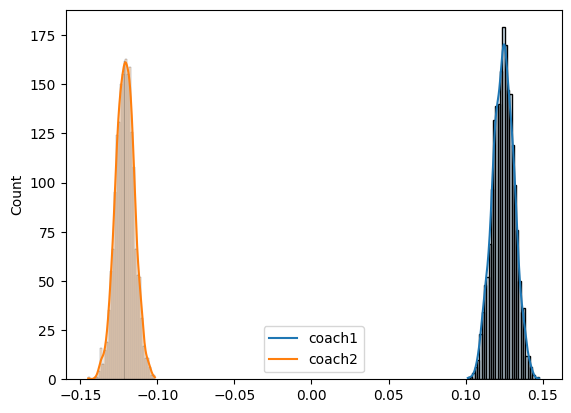

In [39]:
#Plotting the data
coach1_skill_inf = samples["coach1_skill"].detach().squeeze()
coach2_skill_inf= samples["coach2_skill"].detach().squeeze()

sns.histplot(coach1_skill_inf, kde=True, alpha=0.2)
sns.histplot(coach2_skill_inf, kde=True, alpha=0.2)
plt.legend(["coach1", "coach2"])
plt.show()